# Word2Vec from scratch

Word2vec word embeddings make use of neural networks to learn how to map words into vectors in such a way that words that appear in similiar contexts have similiar vectors.

Various libraries (such as gensim) allow you to build your own word2vec models and various pre-trained word embeddings are available to download online. Also, neural network libraries (such as keras) often allow you to train an embedding as the first layer of a neural network. These pre-trained vectors have often been trained on a very large corpus with a carefully trained neural network so in practice are the best place to start unless there is a compelling reason not to. Neural network libraries (such as keras) often allow you to train an embedding as the first layer of a neural network.

However, in order to aid my own understanding of how word2vec works this notebook sets out build my own skip-gram word word embeddings by hand constructing a neural network. This is based on the [Chris McCormick's blog post.](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

This notebook is purely for explorely the inner workings of word2vec, it is **not** something to be used for generating a useable word2vec model (which is pretty simple in gensim). You will notice that I had to restrict the amount of text considered to avoid memory issues. This could have mitigated by the use of sparse vectors and by limited the number of words to the most commonly occuring ones, but for clarity these steps have been ommitted.

In [1]:
from __future__ import division

import re
import string
import unicodedata
import numpy as np
import pandas as pd

# For getting the data
from sklearn.datasets import fetch_20newsgroups

# For cleaning the text
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# For training the neural network
from keras.layers import Input, Dense
from keras.models import Model

# For displaying the neural network
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


## Fetch the data

Here some of the newsgroups data is downloaded using the sklearn function. Headers and footers have been removed, and only 150 newsgroup posts are actually used to avoid memory issues.

In [2]:
catagories = ['sci.med', 'sci.electronics', 'sci.space']
text_data = fetch_20newsgroups(categories=catagories,
                               random_state=42,
                               remove=('headers', 'footers', 'quotes'))

df = pd.DataFrame()
df['text'] = text_data.data

# Remove blank lines
df = df[ df['text']!= "" ]

# Restrict to 150 rows
df = df.head(150)

df.head(10)

,text
0,Another fish to check out is Richard Rast -- h...
1,: As the subject says - Can I use a 4052 for d...
2,I am looking for current sources for lists of ...
3,"\n\nBut why do you characterize this as a ""fli..."
4,\nIt was more than a theoretical concept; it w...
5,\n\n\nThe name is rather descriptive. It's a ...
6,My mom has just been diagnosed with cystic bre...
7,\n\nThe yearly chest x-ray provides a minute a...
9,I've recently listened to a tape by Dr. Stanis...
10,We've just been donated a large machine for us...


## Preparing the text

Next we define a tokeniser that aswell as splitting a string of text into individual tokens, also removed punctuation, stopwords and numbers. In addition words have been stemmed.

In [3]:
def tokeniser(text):
    
    # Remove any whitespace at the start and end of the string
    # and remove any stray tabs and newline characters
    text = text.strip()
    
    # Remove any weird unicode characters
    if isinstance(text, unicode):
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')
        
    # Convert hyphens and slashes to spaces
    text = re.sub(r'[-/]+',' ',text)
    
    # Remove numbers
    text = re.sub(r'\S*\d+\S*', '', text)
    
    # Remove remaining punctuation
    text = text.translate(None, string.punctuation)
    
    # Convert the text to lowercase and use nltk tokeniser
    tokens = word_tokenize(text.lower())
    
    # Define a list of stopwords apart from the word 'not'
    stops = set(stopwords.words('english')) - set(('not'))

    # Define stemmer
    stemmer = SnowballStemmer('english')

    return [str(stemmer.stem(i)) for i in tokens if i not in stops]


The apply this function to the text.

In [4]:
df['tokens'] = df['text'].apply(lambda x: tokeniser(x))
df.head(10)

,text,tokens
0,Another fish to check out is Richard Rast -- h...,"[anoth, fish, check, richard, rast, work, lock..."
1,: As the subject says - Can I use a 4052 for d...,"[subject, say, use, digit, signal, dont, see, ..."
2,I am looking for current sources for lists of ...,"[look, current, sourc, list, home, medic, test..."
3,"\n\nBut why do you characterize this as a ""fli...","[character, flight, fanci, fantasi, unfamiliar..."
4,\nIt was more than a theoretical concept; it w...,"[theoret, concept, serious, pursu, freeman, dy..."
5,\n\n\nThe name is rather descriptive. It's a ...,"[name, rather, descript, command, spacecraft, ..."
6,My mom has just been diagnosed with cystic bre...,"[mom, diagnos, cystic, breast, diseas, big, re..."
7,\n\nThe yearly chest x-ray provides a minute a...,"[year, chest, x, ray, provid, minut, amount, r..."
9,I've recently listened to a tape by Dr. Stanis...,"[ive, recent, listen, tape, dr, stanislaw, bur..."
10,We've just been donated a large machine for us...,"[weve, donat, larg, machin, use, robot, lab, d..."


## Mapping words to numbers

In order for the tokens to be used within a model we need to convert the text into numbers. The first step is to create a list of all the unique words appearing in the data.

In [5]:
# Extract all the tokens
all_words = df['tokens'].tolist()

# Flatten
all_words = [ value for row in all_words for value in row]

# Remove duplicates
all_words = list(set(all_words))

The next step is create dictionaries that link the words to a number (and vice versa). The number of unique words is also recorded as this will prove useful later.

In [6]:
word_to_num = {k: v for v, k in enumerate(all_words)}
num_to_word = {v: k for v, k in enumerate(all_words)}

num_words = len(word_to_num)

Keras does not want to be given a number between *0* and *num_words* to describe which word it is seeing. Instead it expects an array of length *num_words*, where if we are considering the word whose associated number is given by *i* the *i*th element of the array has value one.

Below we define a function which takes a word appearing in the training corpus as input (where it has been cleaned and stemmed) and outputs the associated array in the correct format.

In [7]:
def encode_word(word):
    features = np.zeros( len(word_to_num) )
    features[ word_to_num[word] ] = 1
    return features

## Converting the problem into one of prediction

As discussed in [Chris McCormick's blog post.](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) the key part of  word2vec is the transformation of the problem of creating a new representation for words into one of prediction. The blog neatly explains the concepts (with diagrams) so only a brief outline is presented here.

The first step is to apply a rolling window to each row of data. If the window size is set to five, for example, the two words precedding a given word and the two words following a given word are considered.

The prediction challenge then becomes: given the preceeding (or following) word predict the middle word.

So if our window was of size three and looked liked:
    $$x_0, \, x_1, \, x_2, \, x_3, \, x_4$$

We would be have four data points:
    $$\left( x_0, x_2\right), \, \left( x_1, x_2\right), \, \left( x_3, x_2\right), \, \left( x_4, x_2\right)$$

where we are trying to predict the second number from each pair from the first.

### Create the features

The first step is to apply this rolling window and create these input / ouput pairs.

In [8]:
# Define the window size
window = 5

# Halve the window size
half_wind = int(window/2)


input_output = []

# Loop over each post
for row in df['tokens']:
    
    # Loop over each word in the post and consider the window around it
    for i, word in enumerate(row):
    
        # Look at the preceeding half window
        for j in xrange(i-half_wind, i):
            if(j >= 0):
                input_output.append( (row[j], row[i]) )
    
        # Look at the following half window
        for j in xrange(i+1, i+half_wind+1):
            if(j< len(row)):
                input_output.append( (row[j], row[i]) )

print "Tokens from the first post are:"
print df['tokens'][0]
print ""
print "The first few input / output pairs are:"
print input_output[:5]

Tokens from the first post are:
['anoth', 'fish', 'check', 'richard', 'rast', 'work', 'lockhe', 'missil', 'site', 'nasa', 'johnson', 'nick', 'johnson', 'kaman', 'scienc', 'colo', 'spgs', 'friend', 'darren', 'mcknight', 'kaman', 'alexandria', 'va', 'good', 'luck', 'r', 'landi']

The first few input / output pairs are:
[('fish', 'anoth'), ('check', 'anoth'), ('anoth', 'fish'), ('check', 'fish'), ('richard', 'fish')]


Next these inputs and outputs need to be encoded into the expected format.

In [9]:
X = []
y = []
for tup in input_output:
    X.append(encode_word(tup[0]))
    y.append(encode_word(tup[1]))

X = np.array(X)
y = np.array(y)

Is this the expected format?

In [10]:
print "First X value is:"
print input_output[0][0]

print ""

print "First feauture is:"
first_feat = X[0,:]
print first_feat

print ""

print "Which index of the first feature has a one?"
first_arg = np.argwhere(first_feat)[0][0]
print first_arg

print ""
print "What word does this argument correspond to?"
print num_to_word[first_arg]

First X value is:
fish

First feauture is:
[ 0.  0.  0. ...,  0.  0.  0.]

Which index of the first feature has a one?
2276

What word does this argument correspond to?
fish


### Build the neural network

Next build the neural network. The first step is to specify the layers, the number of neurons in the first layer determines the number of dimensions of the word embedding.

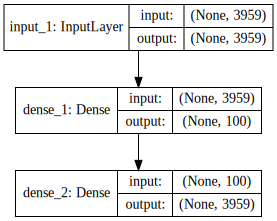

In [11]:
inputs = Input(shape=(num_words,))
x = Dense(100, activation=None)(inputs)
predictions = Dense(num_words, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Then fit the model. The number of epochs has been constrained to keep execution time down (it is only a toy model after all).

In [12]:
model.fit(X, y, epochs=5, batch_size=100)

Epoch 1/5
61472/61472 [==============================] - 23s - loss: 7.7475 - acc: 0.0083    
Epoch 2/5
61472/61472 [==============================] - 23s - loss: 7.5875 - acc: 0.0087    
Epoch 3/5
61472/61472 [==============================] - 23s - loss: 7.5409 - acc: 0.0096    
Epoch 4/5
61472/61472 [==============================] - 23s - loss: 7.4795 - acc: 0.0123    
Epoch 5/5
61472/61472 [==============================] - 23s - loss: 7.4105 - acc: 0.0150    


## Extracting the weights

The word2vec model is just the weights from the first layer of the trained neural network. This can be extracted from the model as follows:

In [13]:
word2vec = model.layers[2].get_weights()[0]
print word2vec.shape

(100, 3959)


The *i*th column of this matrix is the vector associated with the *i*th word. A function can be written to take a word that appears in the corpus (cleaned and stemmed) that returns the associated vector.

In [14]:
def lookup_word(word):
    return word2vec[:, word_to_num[word]]

lookup_word('fish')

array([-1.97141325,  0.67672294, -0.96810716, -0.84520632, -0.41413036,
        1.11274695, -2.10097265,  1.38101363, -0.64868277,  1.04028881,
       -0.94923067, -0.59151566,  1.25863171, -2.06790137, -0.8669197 ,
       -0.74480015,  1.18164492,  0.79420584,  0.75332636,  1.1417706 ,
       -2.08621573, -0.63764066,  0.6852352 ,  1.73760247, -1.02486575,
       -0.80407125,  1.61554611, -0.80632335, -1.73476946,  2.08853555,
        1.83512485, -1.36123836, -1.65640235,  0.48223022, -0.70910507,
        1.85455203, -0.75441939,  1.77476239,  1.04991508, -1.22752595,
       -0.84015119, -0.88672745, -2.08637238,  0.28832033, -1.36546981,
        1.09845233, -0.62574017, -1.39769268,  1.57041049,  1.36418021,
        2.20699096,  1.98577929,  2.18315649,  0.27575612,  0.66500497,
        1.14938056, -1.111305  ,  1.04218936,  1.28551495,  1.08309782,
       -1.06331027, -0.50949413, -2.11069012, -0.86842036, -2.04522061,
        1.24561775, -1.55559301, -0.30805171,  2.18879652, -1.35

This demonstrates some of the things going on under-the-hood when a skip-gram word2vec model is trained.